
# EDA del Dataset **TrashNet** (Clasificación de Residuos)

Este notebook realiza un **Análisis Exploratorio de Datos (EDA)** completo del dataset TrashNet.  
Objetivos principales:

1) **Inventariar** el dataset (rutas, clases, tamaños)  
2) **Diagnosticar balance** por clase y posibles sesgos  
3) **Caracterizar** las imágenes (dimensiones, brillo/contraste, color promedio, nitidez, densidad de bordes)  
4) **Detectar duplicados** y similitudes fuertes  
5) **Explorar estructura** global con una proyección PCA de histogramas RGB  
6) **Exportar metadatos** para trazabilidad / futuros experimentos



## 1) Importación de librerías y configuración
Se fijan semillas para reproducibilidad y se configuran opciones de impresión.


In [8]:

import os, math, random, hashlib, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import kagglehub

np.random.seed(42); random.seed(42)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", 200)



## 2) Carga del dataset y descubrimiento de estructura de carpetas
Se descarga el dataset desde Kaggle (o se reutilizan variables si ya están definidas) y se infieren las **clases** desde las subcarpetas.


In [9]:

try:
    dataset_path
    categories
    all_image_paths
except NameError:
    path = kagglehub.dataset_download("feyzazkefe/trashnet")
    subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    dataset_path = os.path.join(path, subdirs[0])
    categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    all_image_paths = []
    for c in categories:
        cp = os.path.join(dataset_path, c)
        ps = [os.path.join(cp, f) for f in os.listdir(cp) if f.lower().endswith((".jpg",".jpeg",".png"))]
        all_image_paths.extend(ps)

len(dataset_path), len(categories), len(all_image_paths), sorted(categories)[:10]


(81, 6, 2527, ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])


## 3) Inventario: tabla de rutas y etiquetas
Se construye un `DataFrame` con **ruta** y **clase** para cada imagen, ordenado aleatoriamente.


In [10]:

labels = [os.path.basename(os.path.dirname(p)) for p in all_image_paths]
df = pd.DataFrame({"path": all_image_paths, "label": labels}).sample(frac=1, random_state=42).reset_index(drop=True)
df.head(10)


,path,label
0,/home/jp/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/plastic/plastic156.jpg,plastic
1,/home/jp/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/glass/glass329.jpg,glass
2,/home/jp/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/paper/paper382.jpg,paper
3,/home/jp/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/trash/trash3.jpg,trash
4,/home/jp/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/trash/trash107.jpg,trash
5,/home/jp/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/paper/paper394.jpg,paper
6,/home/jp/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/cardboard/cardboard295.jpg,cardboard
7,/home/jp/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/glass/glass40.jpg,glass
8,/home/jp/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/metal/metal168.jpg,metal
9,/home/jp/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/plastic/plastic73.jpg,plastic



## 4) Balance por clase
Se cuantifica el **número de imágenes por clase** y su **porcentaje** relativo para detectar desbalances.


In [11]:

cnt = df["label"].value_counts().rename_axis("label").reset_index(name="count")
cnt["pct"] = (cnt["count"] / cnt["count"].sum()).round(4)
cnt


,label,count,pct
0,paper,594,0.2351
1,glass,501,0.1983
2,plastic,482,0.1907
3,metal,410,0.1622
4,cardboard,403,0.1595
5,trash,137,0.0542


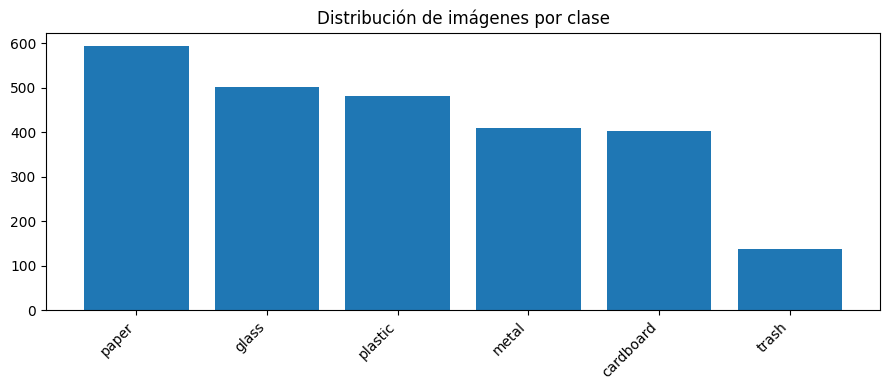

In [12]:

plt.figure(figsize=(9,4))
x = np.arange(len(cnt))
plt.bar(x, cnt["count"].values)
plt.xticks(x, cnt["label"].values, rotation=45, ha="right")
plt.title("Distribución de imágenes por clase")
plt.tight_layout()
plt.show()



## 5) Muestra visual por clase
Se muestran **n=5** ejemplos por clase para observar variabilidad intra-clase, condiciones de iluminación, fondo, escala, etc.


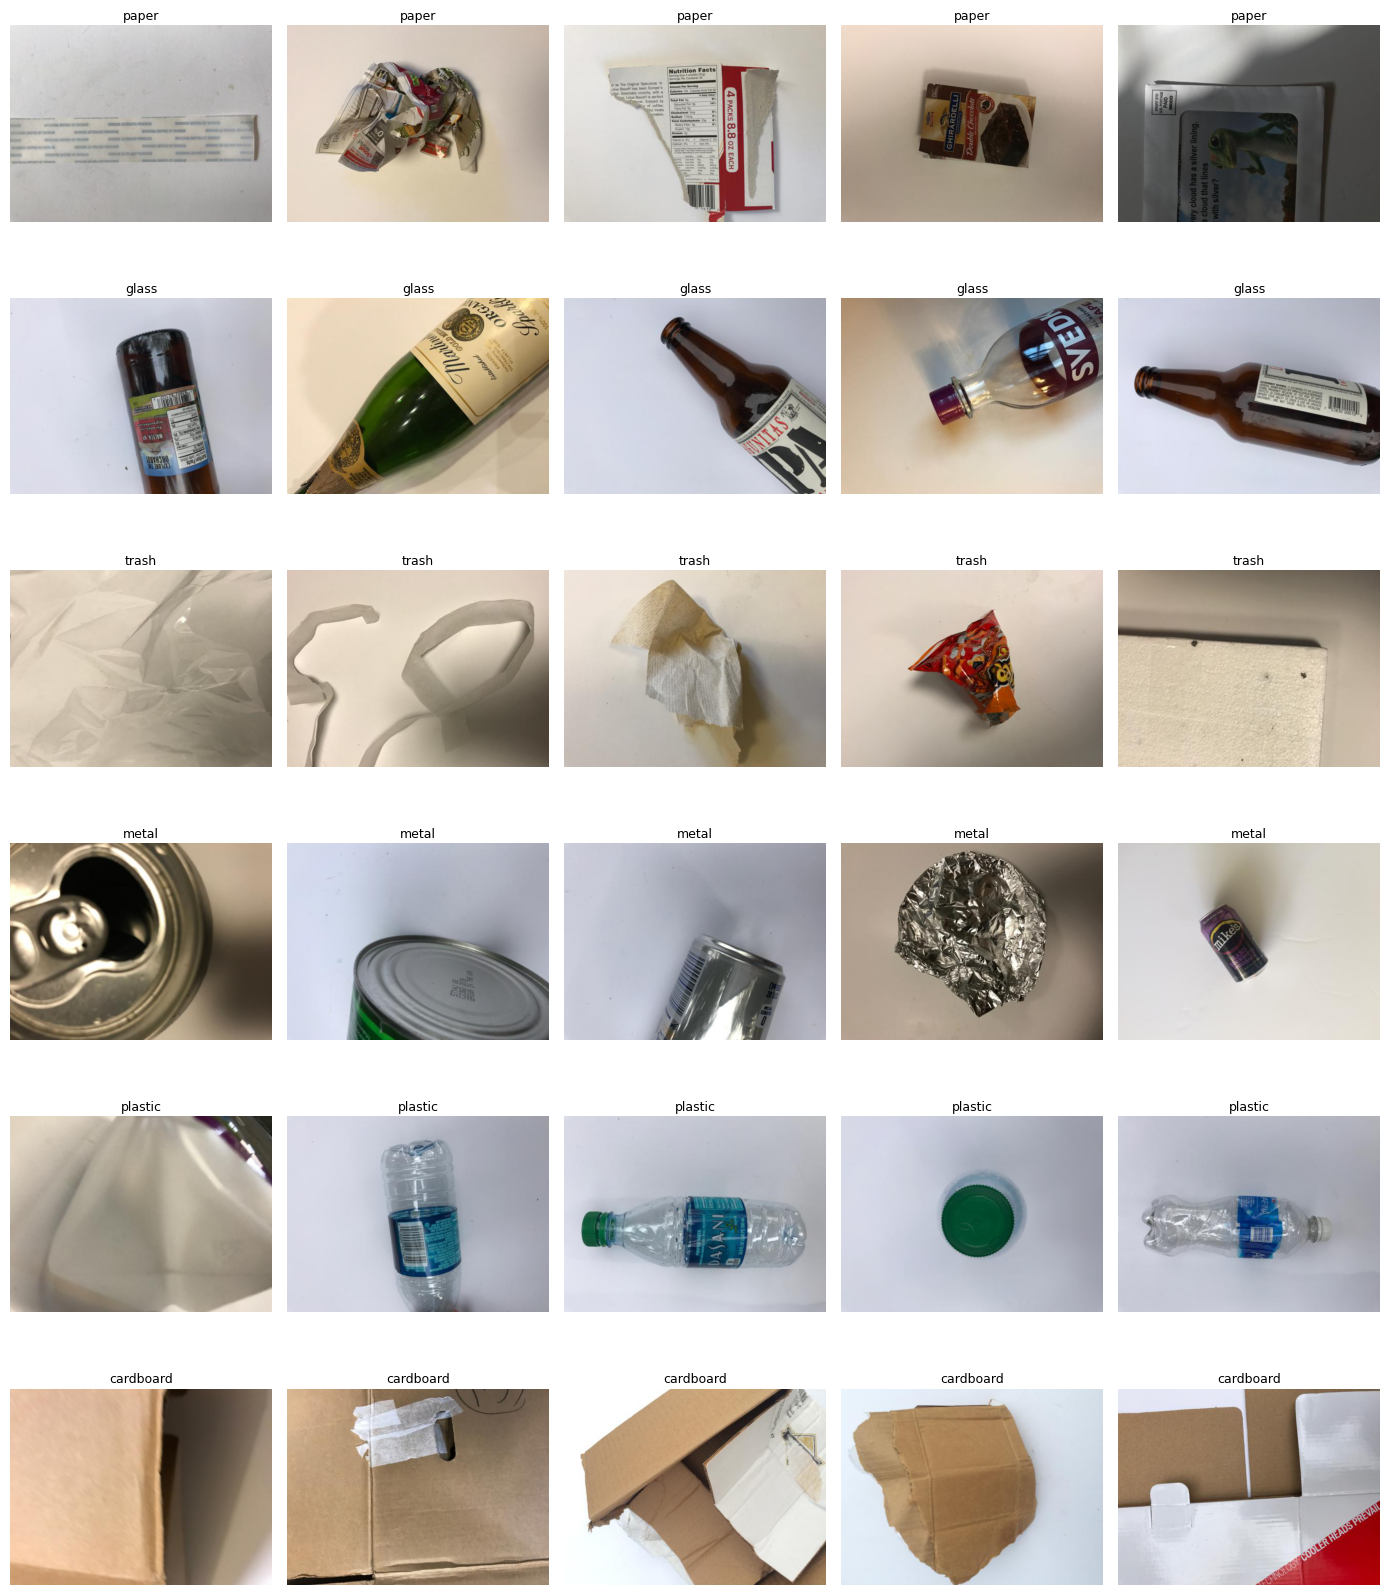

In [13]:
n = 5
r = len(categories)
c = n

fig, axes = plt.subplots(r, c, figsize=(c*2.8, r*2.8))

for i, cl in enumerate(categories):
    sample = df[df.label == cl].head(n)
    for j, (_, row) in enumerate(sample.iterrows()):
        im = Image.open(row["path"])
        axes[i, j].imshow(im)
        axes[i, j].axis("off")
        axes[i, j].set_title(cl, fontsize=9, pad=4)

plt.tight_layout()
plt.show()


| Columna | Clase / Subcategoría | Descripción visual                                                                                     |
| ------- | -------------------- | ------------------------------------------------------------------------------------------------------ |
| 1       | **Metal**            | Latas de aluminio o envases metálicos (por ej. Monster, latas plateadas, a veces arrugadas o enteras). |
| 2       | **Glass**            | Botellas o frascos de vidrio, transparentes o de color (verde, marrón, transparente).                  |
| 3       | **Paper**            | Hojas impresas, papeles arrugados o con texto/imágenes.                                                |
| 4       | **Trash**            | Residuos varios no reciclables, generalmente papel o material sucio o deformado.                       |
| 5       | **Cardboard**        | Cartón corrugado, cajas marrones o beige, con textura visible.                                         |
| 6       | **Plastic**          | Botellas y envases plásticos (transparente, con etiquetas de colores).                                 |


### Desbalance de clases

El dataset TrashNet presenta un desbalance en la cantidad de imágenes por categoría.  
Este fenómeno se debe principalmente a diferencias en la facilidad de recolección y variabilidad de los objetos:

- **Trash (residuos genéricos)** tiene menos ejemplos porque es una categoría más difusa y difícil de definir visualmente.  
- **Paper** y **Plastic** tienen muchas más imágenes ya que son materiales comunes y fáciles de fotografiar.  
- **Metal** y **Cardboard** presentan menor frecuencia en el entorno de recolección.

El desbalance afecta el entrenamiento de modelos de clasificación, ya que puede generar sesgo hacia las clases mayoritarias.  
Para mitigarlo se deberian aplicar técnicas de data augmentation, class weighting o samplers balanceados durante el entrenamiento

Otro problema que notamos es la similitud entre algunas imagenes de las distintas categorías

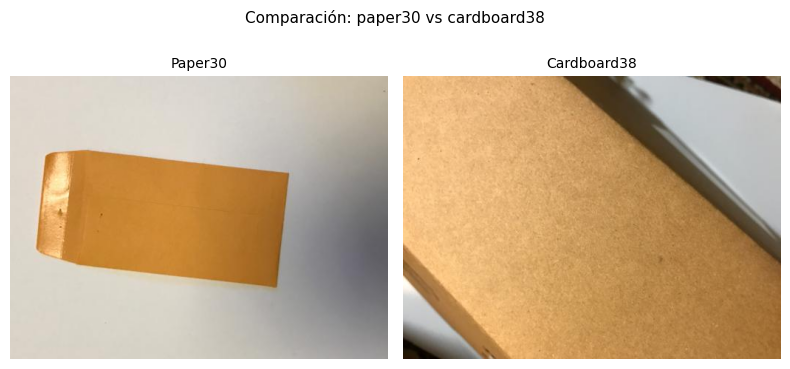

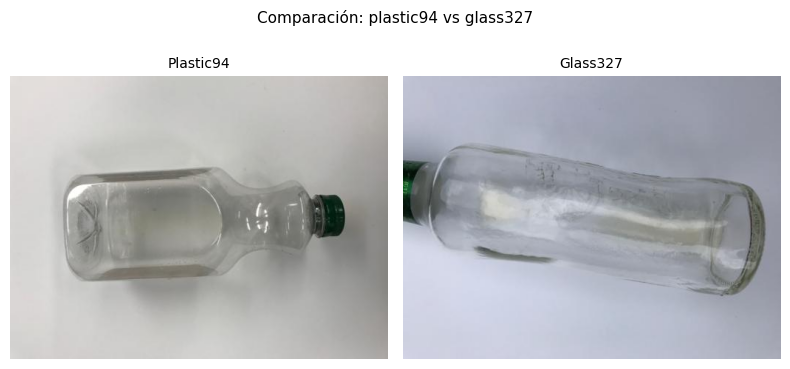

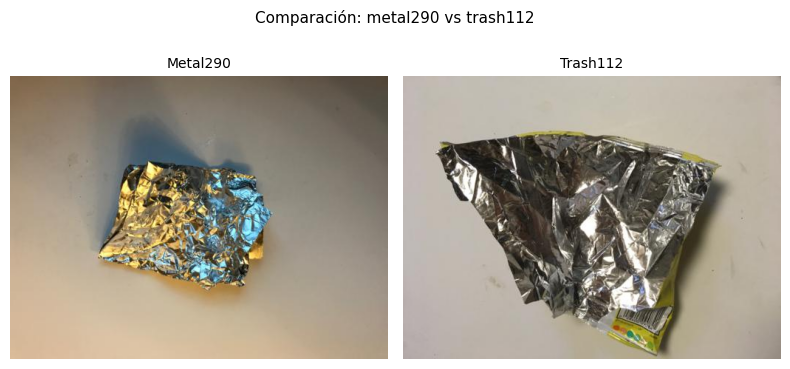

In [ ]:
import matplotlib.image as mpimg

# PARES DE IMÁGENES A COMPARAR ENTRE CLASES SIMILARES
image_pairs = [
    ("paper30.jpg", "cardboard38.jpg"),
    ("plastic94.jpg", "glass327.jpg"),
    ("metal290.jpg", "trash112.jpg")
]

all_image_paths = {}
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_image_paths[file] = os.path.join(root, file)

for img1_name, img2_name in image_pairs:
    if img1_name not in all_image_paths or img2_name not in all_image_paths:
        print(f"⚠️  No se encontró alguno de los archivos: {img1_name}, {img2_name}")
        continue

    img1 = mpimg.imread(all_image_paths[img1_name])
    img2 = mpimg.imread(all_image_paths[img2_name])

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img1)
    axes[0].set_title(img1_name.split('.')[0].capitalize(), fontsize=10)
    axes[0].axis("off")

    axes[1].imshow(img2)
    axes[1].set_title(img2_name.split('.')[0].capitalize(), fontsize=10)
    axes[1].axis("off")

    plt.suptitle(f"Comparación: {img1_name.split('.')[0]} vs {img2_name.split('.')[0]}", fontsize=11)
    plt.tight_layout()
    plt.show()



## 6) Extracción de metadatos por imagen
Para cada imagen se calculan:

- **Dimensiones**: `width`, `height`, `aspect`  
- **Tamaño de archivo**: `filesize` (bytes)  
- **Color promedio**: `r_mean`, `g_mean`, `b_mean`  
- **Brillo/Contraste** en escala de grises: `gray_mean`, `gray_std`  
- **Nitidez aproximada**: varianza del gradiente (`blur_var`)  
- **Complejidad de bordes**: porcentaje de píxeles por encima del percentil 90 del gradiente (`edge_density`)  
- **Hash perceptual simple**: MD5 de una versión 16×16 en gris (sirve para detectar duplicados exactos o casi exactos)  
- **Histogramas RGB**: 16 bins por canal → 48 features en total


In [ ]:

def feats(p):
    st = os.stat(p)
    im = Image.open(p).convert("RGB")
    w,h = im.size
    fs = st.st_size
    arr = np.array(im)
    r,g,b = arr[:,:,0].astype(np.float32), arr[:,:,1].astype(np.float32), arr[:,:,2].astype(np.float32)
    gray = (0.299*r + 0.587*g + 0.114*b).astype(np.float32)
    gx = np.zeros_like(gray); gy = np.zeros_like(gray)
    gx[:,1:-1] = gray[:,2:] - gray[:,:-2]
    gy[1:-1,:] = gray[2:,:] - gray[:-2,:]
    grad = np.hypot(gx, gy)
    thr = np.percentile(grad, 90)

    r_mean, g_mean, b_mean = float(r.mean()), float(g.mean()), float(b.mean())
    gray_mean, gray_std = float(gray.mean()), float(gray.std())
    blur_var = float(grad.var())
    edge_density = float((grad>=thr).mean())

    im_small = im.convert("L").resize((16,16), Image.BILINEAR)
    hsh = hashlib.md5(np.array(im_small).tobytes()).hexdigest()

    hist = []
    for ch in (r,g,b):
        h,_ = np.histogram(ch, bins=16, range=(0,255), density=True)
        hist.extend(h.tolist())

    return [w,h,(w/(h+1e-6)),fs,r_mean,g_mean,b_mean,gray_mean,gray_std,blur_var,edge_density,hsh]+hist

cols = ["width","height","aspect","filesize","r_mean","g_mean","b_mean","gray_mean","gray_std","blur_var","edge_density","hash"]+[f"hist_{i}" for i in range(48)]
M = [feats(p) for p in df["path"]]
meta_df = pd.concat([df, pd.DataFrame(M, columns=cols)], axis=1)
meta_df.head(10)


,path,label,width,height,aspect,filesize,r_mean,g_mean,b_mean,gray_mean,...,hist_38,hist_39,hist_40,hist_41,hist_42,hist_43,hist_44,hist_45,hist_46,hist_47
0,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/glass/glass228.jpg,glass,512,"[1.3403799019607843e-05, 0.0010221992442810458, 0.0004359426062091503, 9.957107843137256e-05, 0.00010850694444444444, 0.0005131740196078432, 0.0007151884191176471, 0.0009679457720588236, 0.0013518...","[35546177.73429191, 500391.299995299, 1171778.610564066, 5090926.815002559, 4675502.568330268, 995771.8213582606, 714895.6703751092, 528409.3442217085, 378455.0080122035, 86565.03149852678, 29422....",6640,198.837662,182.248657,168.419785,185.632309,...,0.000715,0.000968,0.001352,0.005914,0.017401,0.034202,0.000001,0.000000,0.000000e+00,0.000000
1,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/metal/metal167.jpg,metal,512,"[0.00043562346813725487, 0.00034594566993464054, 0.00031498927696078433, 0.0003497753267973856, 0.0004866855596405229, 0.000475515727124183, 0.0005690231821895425, 0.0014045266544117647, 0.0110316...","[1172635.0903315395, 1475735.3798260496, 1620308.1475563534, 1459623.7559654266, 1049856.7978461357, 1074466.1106779578, 898209.0834154024, 364276.26498074504, 46407.72598649246, 86949.74133795002...",10251,196.854813,186.320923,173.508545,188.009949,...,0.000569,0.001405,0.011032,0.005887,0.004175,0.008849,0.025630,0.002787,3.510519e-06,0.000000
2,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/plastic/plastic263.jpg,plastic,512,"[3.925398284313726e-05, 0.00036988102532679737, 0.000690295649509804, 0.0004059436274509804, 0.0027627782883986925, 0.0034744561887254904, 0.0015899458741830067, 0.001756216809640523, 0.0036605136...","[12719238.292398907, 1380496.6149154094, 740638.2498762403, 1258159.5225045623, 185253.64431336062, 147318.78987885016, 321821.1306295544, 291369.8510001966, 139832.87899421487, 136408.7303476764,...",17619,173.742798,173.023575,168.711182,172.747025,...,0.001590,0.001756,0.003661,0.003752,0.005970,0.014183,0.015715,0.006235,1.688240e-03,0.000452
3,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/cardboard/cardboard225.jpg,cardboard,512,"[0.00020584405637254902, 0.0013952716503267974, 0.0011399611928104576, 0.0007455065359477124, 0.0014808006535947712, 0.003004365808823529, 0.015758718852124185, 0.02243221507352941, 0.008447584763...","[2475294.7170878886, 366690.82257751666, 448744.44742403796, 685861.376082931, 345525.5595669463, 170361.95676972377, 32487.889206918793, 22823.300107533236, 60601.86579862607, 249306.6064532144, ...",22185,169.142227,142.304016,116.730461,147.413254,...,0.015759,0.022432,0.008448,0.002053,0.004196,0.001242,0.000556,0.000088,0.000000e+00,0.000000
4,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/cardboard/cardboard69.jpg,cardboard,512,"[8.61672794117647e-06, 0.00012957005718954248, 0.0006925296160130719, 0.0011323018790849674, 0.0011150684232026143, 0.001827065461601307, 0.006340316074346405, 0.00918383629493464, 0.0140609043096...","[53240561.98031157, 3921266.5676997704, 738252.5391537852, 451777.2443943982, 458753.2353355096, 280077.497635949, 80740.3374941804, 55744.05286704606, 36410.431242160026, 48850.97169167618, 65131...",22891,170.049820,154.899658,140.055237,157.737289,...,0.006340,0.009184,0.014061,0.010480,0.007860,0.006597,0.002332,0.000678,2.444598e-04,0.000064
5,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/plastic/plastic389.jpg,plastic,512,"[0.0, 1.5956903594771242e-06, 2.8084150326797384e-05, 0.00015318627450980392, 0.0004276450163398693, 0.0009213516135620916, 0.003043938929738562, 0.0047347324346405225, 0.005057700163398693, 0.002...","[512000000.0, 197250029.50780973, 17604090.00252816, 3320658.739746932, 1194461.571889685, 555102.8398190499, 168147.87153841546, 108114.21613579075, 101211.7705066774, 172542.2946823185,


## 7) Resumen estadístico de metadatos
Tabla descriptiva de las variables numéricas.


In [ ]:

meta_df.describe()


,width,filesize,r_mean,g_mean,b_mean,gray_mean,gray_std,blur_var,edge_density,hist_0,...,hist_38,hist_39,hist_40,hist_41,hist_42,hist_43,hist_44,hist_45,hist_46,hist_47
count,2527.0,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,...,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2527.000000,2.527000e+03
mean,512.0,17127.978631,171.634624,163.148632,154.230018,164.669223,46.357304,315.639999,0.100196,0.000498,...,0.003194,0.003661,0.004589,0.005585,0.006411,0.007592,0.008074,0.005978,0.004620,1.394960e-03
std,0.0,7598.745148,19.500281,20.961226,27.537140,19.995146,15.501777,333.500450,0.001164,0.001419,...,0.003410,0.003780,0.004785,0.005283,0.005467,0.006551,0.007324,0.006427,0.006775,4.034325e-03
min,512.0,5604.000000,78.697136,65.638855,53.687618,77.949959,7.521507,1.209941,0.100001,0.000000,...,0.000000,0.000000,0.000018,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,512.0,11907.500000,163.151642,150.815125,135.210266,153.613503,34.904404,94.844913,0.100001,0.000000,...,0.000931,0.001176,0.001567,0.001914,0.002278,0.002525,0.002257,0.000296,0.000036,6.382761e-07
50%,512.0,15385.000000,173.513168,167.571976,158.761429,168.395813,45.030575,197.542953,0.100001,0.000008,...,0.002156,0.002604,0.003275,0.004268,0.005352,0.006574,0.006680,0.004470,0.000698,5.616830e-05
75%,512.0,20303.000000,183.672409,177.106995,176.336555,177.692665,57.464539,411.668030,0.100016,0.000258,...,0.004164,0.004707,0.006075,0.007662,0.009111,0.010664,0.011338,0.009385,0.007201,6.737005e-04
max,512.0,57868.000000,227.692139,223.231979,222.216354,224.449814,98.734764,2809.757812,0.120646,0.022882,...,0.035967,0.052806,0.057111,0.048649,0.042668,0.046585,0.043461,0.046615,0.046514,3.772340e-02



## 8) Distribución de dimensiones y tamaño de archivo
Se inspeccionan histogramas de **ancho**, **alto**, **aspect ratio** y **tamaño en KB** para detectar tamaños atípicos o necesidad de resize.


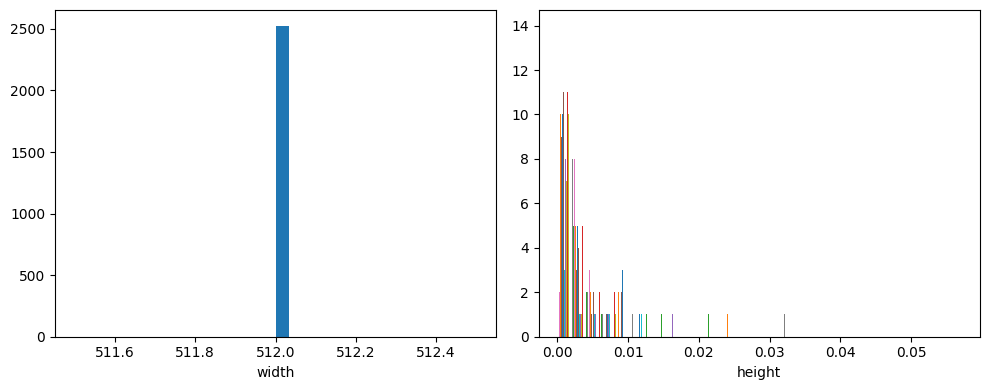

In [ ]:

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(meta_df["width"].dropna(), bins=30)
plt.xlabel("width")
plt.subplot(1,2,2)
plt.hist(meta_df["height"].dropna(), bins=30)
plt.xlabel("height")
plt.tight_layout()
plt.show()


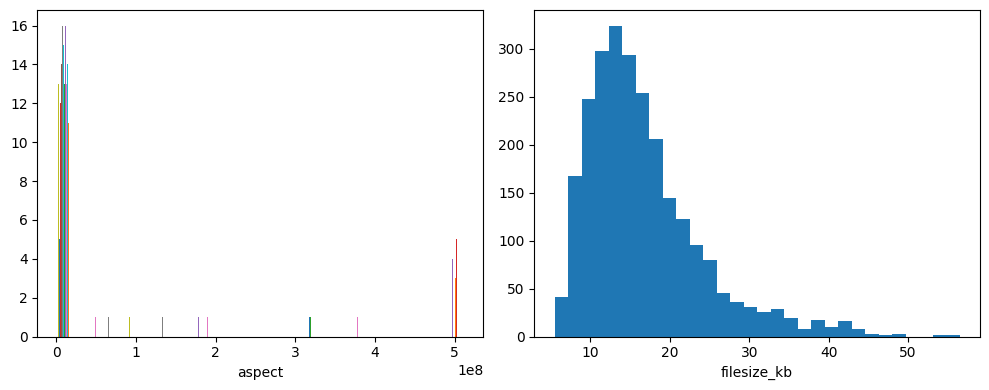

In [ ]:

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(meta_df["aspect"].dropna(), bins=30)
plt.xlabel("aspect")
plt.subplot(1,2,2)
plt.hist((meta_df["filesize"].dropna()/1024.0), bins=30)
plt.xlabel("filesize_kb")
plt.tight_layout()
plt.show()



## 9) Estadísticas por clase: brillo, contraste, nitidez y bordes
Se comparan distribuciones por clase para observar diferencias sistemáticas que puedan afectar el entrenamiento.


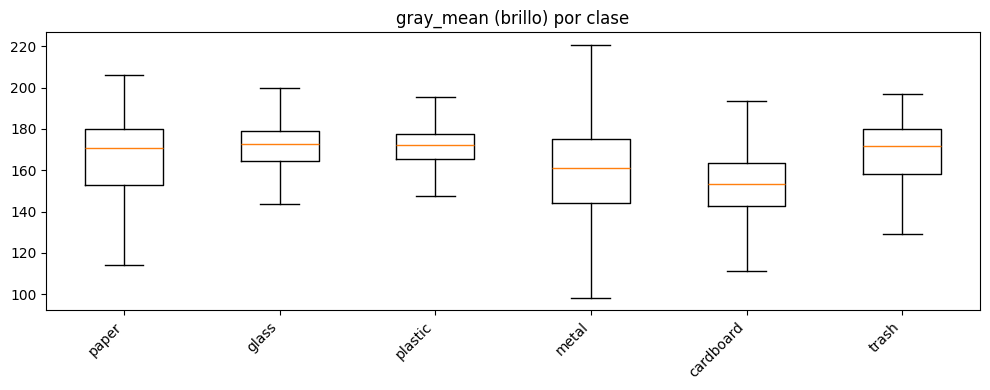

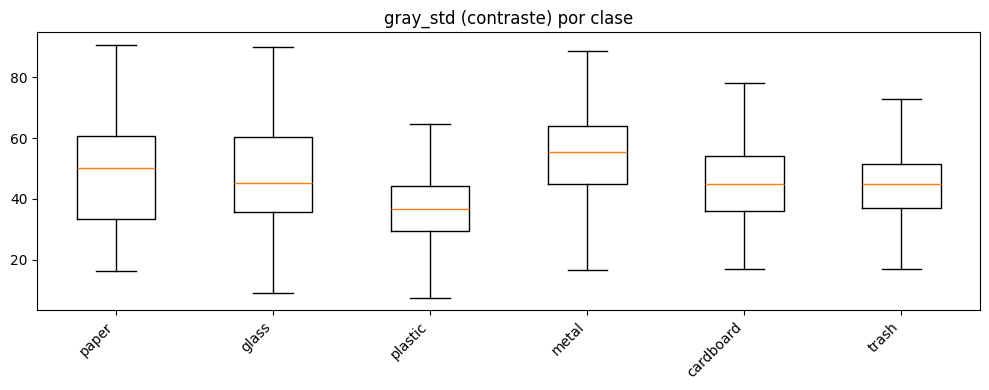

In [ ]:

order = cnt["label"].tolist()
m1 = [meta_df[meta_df.label==cl]["gray_mean"].dropna().values for cl in order]
m2 = [meta_df[meta_df.label==cl]["gray_std"].dropna().values for cl in order]
plt.figure(figsize=(10,4))
plt.boxplot(m1, labels=order, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.title("gray_mean (brillo) por clase")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.boxplot(m2, labels=order, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.title("gray_std (contraste) por clase")
plt.tight_layout()
plt.show()


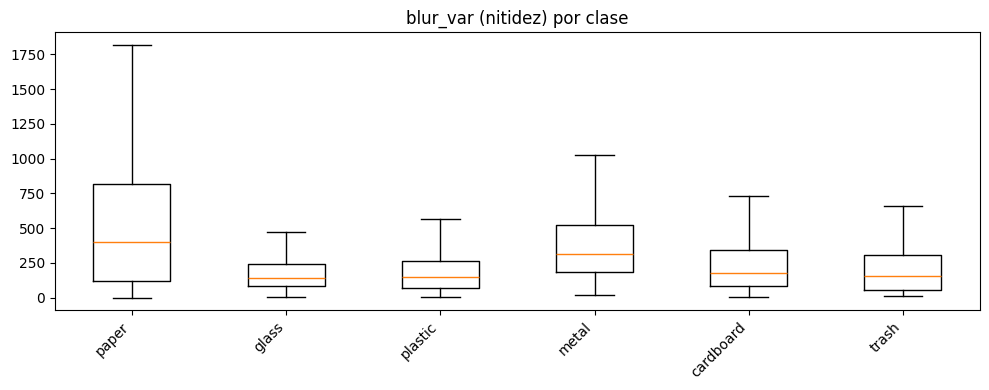

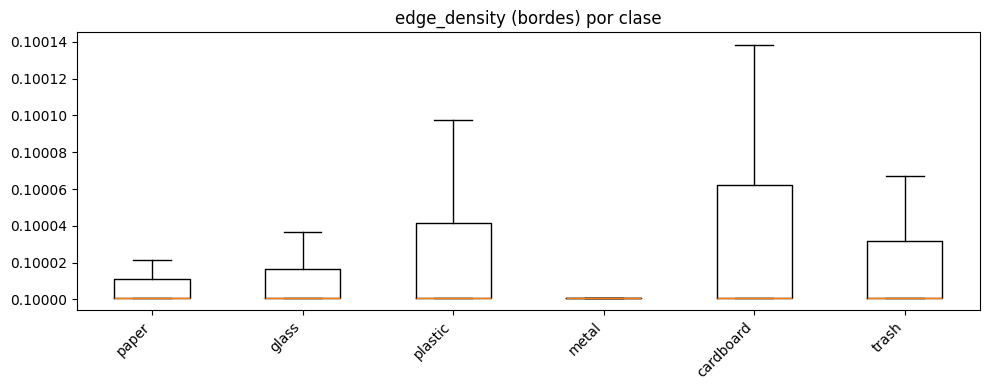

In [ ]:

m3 = [meta_df[meta_df.label==cl]["blur_var"].dropna().values for cl in order]
m4 = [meta_df[meta_df.label==cl]["edge_density"].dropna().values for cl in order]
plt.figure(figsize=(10,4))
plt.boxplot(m3, labels=order, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.title("blur_var (nitidez) por clase")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.boxplot(m4, labels=order, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.title("edge_density (bordes) por clase")
plt.tight_layout()
plt.show()



## 10) Color promedio por clase
Se calculan promedios **R/G/B** por clase para visualizar diferencias cromáticas entre categorías.


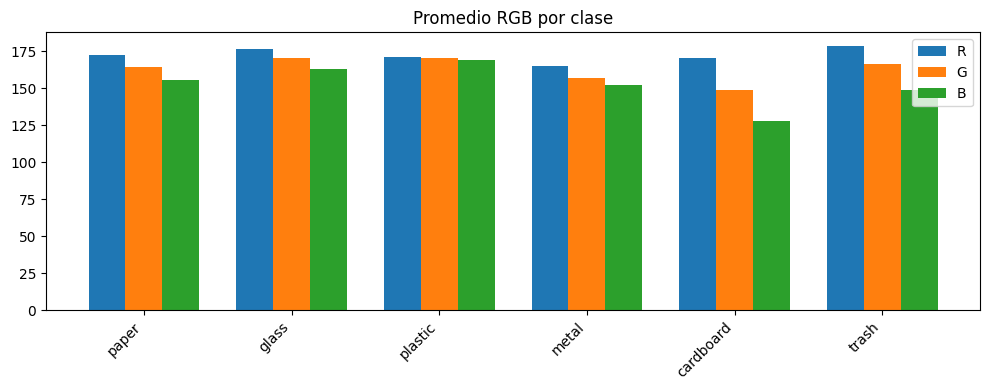

In [ ]:

C = meta_df.groupby("label")[["r_mean","g_mean","b_mean"]].mean().reindex(order)
x = np.arange(len(order)); w = 0.25
plt.figure(figsize=(10,4))
plt.bar(x-w, C["r_mean"].values, width=w, label="R")
plt.bar(x,   C["g_mean"].values, width=w, label="G")
plt.bar(x+w, C["b_mean"].values, width=w, label="B")
plt.xticks(x, order, rotation=45, ha="right")
plt.legend()
plt.title("Promedio RGB por clase")
plt.tight_layout()
plt.show()



## 11) Correlaciones entre metadatos
Matriz de correlación para detectar redundancias o relaciones (p. ej., entre dimensiones y tamaño de archivo).


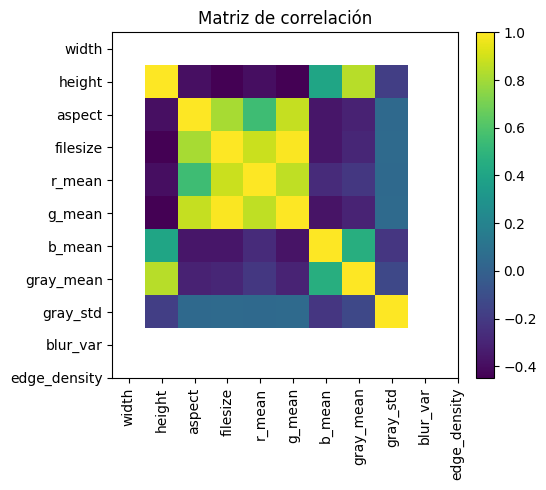

In [ ]:

corr_cols = ["width","height","aspect","filesize","r_mean","g_mean","b_mean","gray_mean","gray_std","blur_var","edge_density"]
C = meta_df[corr_cols].corr(numeric_only=True).values
plt.figure(figsize=(6,5))
plt.imshow(C, interpolation="nearest")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()



## 12) Detección de duplicados
Se marcan imágenes con **hash** repetido como posibles duplicados exactos/casi exactos.


In [ ]:

dup = meta_df.groupby("hash").size().reset_index(name="n")
dup = dup[dup["n"]>1]
dups = meta_df.merge(dup[["hash"]], on="hash", how="inner").sort_values(["hash","label"])
dups.head(20)


,path,label,width,height,aspect,filesize,r_mean,g_mean,b_mean,gray_mean,...,hist_38,hist_39,hist_40,hist_41,hist_42,hist_43,hist_44,hist_45,hist_46,hist_47
0,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/glass/glass389.jpg,glass,512,"[5.2976919934640524e-05, 0.00026711856617647056, 0.0002173330269607843, 0.00032583997140522874, 0.0004831750408496732, 0.0009912428513071895, 0.001959188623366013, 0.0022135416666666666, 0.0028827...","[9485535.681175763, 1909602.9316485724, 2345041.458578607, 1566515.8634015506, 1057468.801162276, 516002.7097453882, 261199.35290757864, 231199.08182656305, 177545.1071692009, 96129.6933581232, 46...",15420,171.105347,172.718979,181.091629,173.190979,...,0.001959,0.002214,0.002883,0.005325,0.011057,0.007713,0.009755,0.012453,0.006855,0.000192
4,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/plastic/plastic332.jpg,plastic,512,"[5.2976919934640524e-05, 0.00026711856617647056, 0.0002173330269607843, 0.00032583997140522874, 0.0004831750408496732, 0.0009912428513071895, 0.001959188623366013, 0.0022135416666666666, 0.0028827...","[9485535.681175763, 1909602.9316485724, 2345041.458578607, 1566515.8634015506, 1057468.801162276, 516002.7097453882, 261199.35290757864, 231199.08182656305, 177545.1071692009, 96129.6933581232, 46...",15420,171.105347,172.718979,181.091629,173.190979,...,0.001959,0.002214,0.002883,0.005325,0.011057,0.007713,0.009755,0.012453,0.006855,0.000192
5,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/glass/glass176.jpg,glass,512,"[0.0, 0.0, 2.8722426470588235e-06, 0.00012637867647058825, 0.001174108966503268, 0.0033745659722222224, 0.006264042075163398, 0.00701593137254902, 0.007010186887254902, 0.009661585988562092, 0.010...","[512000000.0, 512000000.0, 132223118.9176359, 4019511.0687794033, 435704.2747478484, 151678.26794477878, 81723.31388319471, 72966.36846171794, 73026.1520956923, 52987.885500431315, 46662.838582671...",16192,173.288925,163.435532,149.085556,164.745789,...,0.006264,0.007016,0.007010,0.009662,0.010971,0.012893,0.003177,0.000824,0.000245,0.000006
1,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/plastic/plastic152.jpg,plastic,512,"[0.0, 0.0, 2.8722426470588235e-06, 0.00012637867647058825, 0.001174108966503268, 0.0033745659722222224, 0.006264042075163398, 0.00701593137254902, 0.007010186887254902, 0.009661585988562092, 0.010...","[512000000.0, 512000000.0, 132223118.9176359, 4019511.0687794033, 435704.2747478484, 151678.26794477878, 81723.31388319471, 72966.36846171794, 73026.1520956923, 52987.885500431315, 46662.838582671...",16192,173.288925,163.435532,149.085556,164.745789,...,0.006264,0.007016,0.007010,0.009662,0.010971,0.012893,0.003177,0.000824,0.000245,0.000006
3,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/glass/glass115.jpg,glass,512,"[0.00040658190359477126, 0.00013531454248366014, 8.616727941176471e-05, 9.989021650326798e-05, 0.00015446282679738561, 0.0013196359272875816, 0.004051457822712418, 0.005901820363562091, 0.00650467...","[1256189.2357935596, 3756018.9153066543, 5873763.681224825, 5074823.087364626, 3293391.8065653634, 387692.0121744552, 126343.07928646245, 86738.19775383282, 78700.5532596602, 68624.86622884123, 53...",8672,195.447189,180.332321,158.860107,182.403809,...,0.004051,0.005902,0.006505,0.007460,0.009610,0.019489,0.007461,0.000065,0.000000,0.000000
2,/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/metal/metal91.jpg,metal,512,"[0.00040658190359477126, 0.00013531454248366014, 8.616727941176471e-05, 9.989021650326798e-05, 0.00015446282679738561, 0.0013196359272875816, 0.004051457822712418, 0.005901820363562091, 0.00650467...","[1256189.2357935596, 3756018.9153066543, 5873763.681224825, 5074823.087364626, 3293391.8065653634, 387692.0121744552, 126343.07928646245, 86738.19775383282, 78700.5532596602, 68624.86622884123, 53...",8672,195.447189,180.332321,158


## 13) Proyección PCA de histogramas RGB
Se proyectan los **48 histogramas** (16×3) a 2D para observar agrupamientos o solapamientos entre clases.


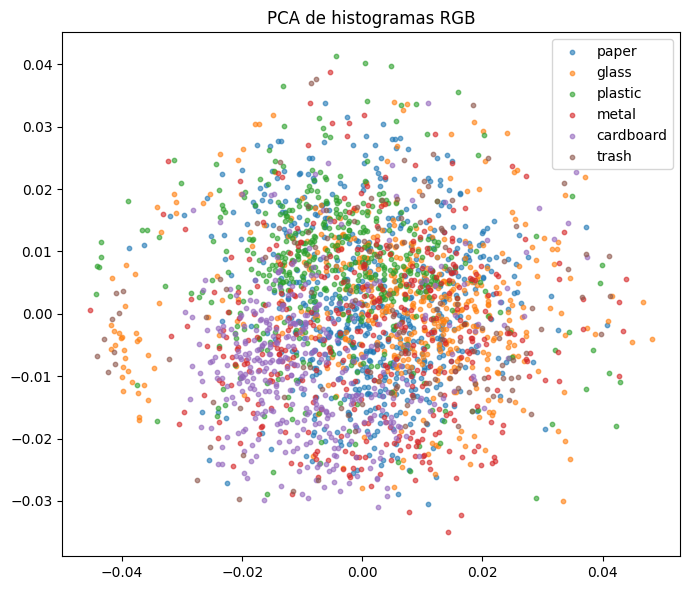

In [ ]:

H = meta_df[[f"hist_{i}" for i in range(48)]].fillna(0).values
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(H)
meta_df["pca_x"] = X2[:,0]; meta_df["pca_y"] = X2[:,1]
plt.figure(figsize=(7,6))
for cl in order:
    m = meta_df.label==cl
    plt.scatter(meta_df.loc[m,"pca_x"], meta_df.loc[m,"pca_y"], s=10, alpha=0.6, label=cl)
plt.legend()
plt.title("PCA de histogramas RGB")
plt.tight_layout()
plt.show()



## 14) Exportación de metadatos
Se guarda una tabla con todos los metadatos calculados para trazabilidad y posteriores análisis.


In [ ]:

meta_df.to_csv("trashnet_metadata.csv", index=False)
meta_df.shape


(2527, 64)

---
# BASELINE CON CONCLUSIONES PARCIALES

## 15) Preparación de datos para entrenamiento

A partir del análisis exploratorio realizado, procedemos a preparar los datos para entrenar un modelo baseline que servirá como referencia inicial.

In [14]:
# Importaciones para PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns

# Configuración de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Dispositivo: cpu


In [15]:
# Dataset personalizado para TrashNet
class TrashNetDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(self.df['label'].unique()))}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'path']
        label = self.df.loc[idx, 'label']
        
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        label_idx = self.label_to_idx[label]
        
        return img, label_idx

# Mostrar mapeo de etiquetas
print("Mapeo de etiquetas:")
temp_dataset = TrashNetDataset(df)
for label, idx in sorted(temp_dataset.label_to_idx.items(), key=lambda x: x[1]):
    print(f"  {idx}: {label}")

Mapeo de etiquetas:
  0: cardboard
  1: glass
  2: metal
  3: paper
  4: plastic
  5: trash


In [16]:
# División estratificada del dataset
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.176, stratify=train_val_df['label'], random_state=42)

print("Distribución del dataset:")
print(f"  Train:      {len(train_df):4d} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Validation: {len(val_df):4d} ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test:       {len(test_df):4d} ({len(test_df)/len(df)*100:.1f}%)")
print(f"  Total:      {len(df):4d}")

print("\nDistribución por clase:")
dist_summary = pd.DataFrame({
    'train': train_df['label'].value_counts().sort_index(),
    'val': val_df['label'].value_counts().sort_index(),
    'test': test_df['label'].value_counts().sort_index()
})
print(dist_summary)

Distribución del dataset:
  Train:      1769 (70.0%)
  Validation:  378 (15.0%)
  Test:        380 (15.0%)
  Total:      2527

Distribución por clase:
           train  val  test
label                      
cardboard    282   60    61
glass        351   75    75
metal        287   61    62
paper        416   89    89
plastic      338   72    72
trash         95   21    21


In [17]:
# Transformaciones básicas (sin data augmentation para baseline)
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear datasets y dataloaders
train_dataset = TrashNetDataset(train_df, transform=basic_transform)
val_dataset = TrashNetDataset(val_df, transform=basic_transform)
test_dataset = TrashNetDataset(test_df, transform=basic_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Batches por época:")
print(f"  Train: {len(train_loader)}")
print(f"  Val:   {len(val_loader)}")
print(f"  Test:  {len(test_loader)}")

Batches por época:
  Train: 56
  Val:   12
  Test:  12


## 16) Modelo Baseline: CNN Simple

Implementamos una CNN básica para establecer una línea base de desempeño.

In [18]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(BaselineCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

model_baseline = BaselineCNN(num_classes=len(categories)).to(device)
print("Arquitectura del modelo baseline:")
print(model_baseline)
print(f"\nParámetros totales: {sum(p.numel() for p in model_baseline.parameters()):,}")

Arquitectura del modelo baseline:
BaselineCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel

## 17) Entrenamiento del Baseline

Configuración: Adam optimizer, lr=0.001, 20 épocas, sin data augmentation.

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_baseline.parameters(), lr=0.001)

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, running_corrects, total = 0.0, 0, 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total += inputs.size(0)
    
    return running_loss / total, running_corrects.double() / total

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss, running_corrects, total = 0.0, 0, 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += inputs.size(0)
    
    return running_loss / total, running_corrects.double() / total

In [20]:
num_epochs = 20
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Iniciando entrenamiento...")
print("="*60)

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model_baseline, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_epoch(model_baseline, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc.item())
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc.item())
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_baseline.state_dict(), 'baseline_best.pth')
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print("-"*60)

print(f"\nMejor val accuracy: {best_val_acc:.4f}")

Iniciando entrenamiento...
Epoch 1/20
  Train Loss: 3.1510 | Train Acc: 0.2629
  Val Loss:   1.5087 | Val Acc:   0.3915
------------------------------------------------------------
Epoch 2/20
  Train Loss: 1.5817 | Train Acc: 0.3657
  Val Loss:   1.3393 | Val Acc:   0.4841
------------------------------------------------------------
Epoch 3/20
  Train Loss: 1.4858 | Train Acc: 0.4098
  Val Loss:   1.3177 | Val Acc:   0.4788
------------------------------------------------------------
Epoch 4/20
  Train Loss: 1.3976 | Train Acc: 0.4398
  Val Loss:   1.4291 | Val Acc:   0.4497
------------------------------------------------------------
Epoch 5/20
  Train Loss: 1.3550 | Train Acc: 0.4822
  Val Loss:   1.2065 | Val Acc:   0.5317
------------------------------------------------------------
Epoch 6/20
  Train Loss: 1.2586 | Train Acc: 0.5269
  Val Loss:   1.1542 | Val Acc:   0.5661
------------------------------------------------------------
Epoch 7/20
  Train Loss: 1.2788 | Train Acc: 0.51

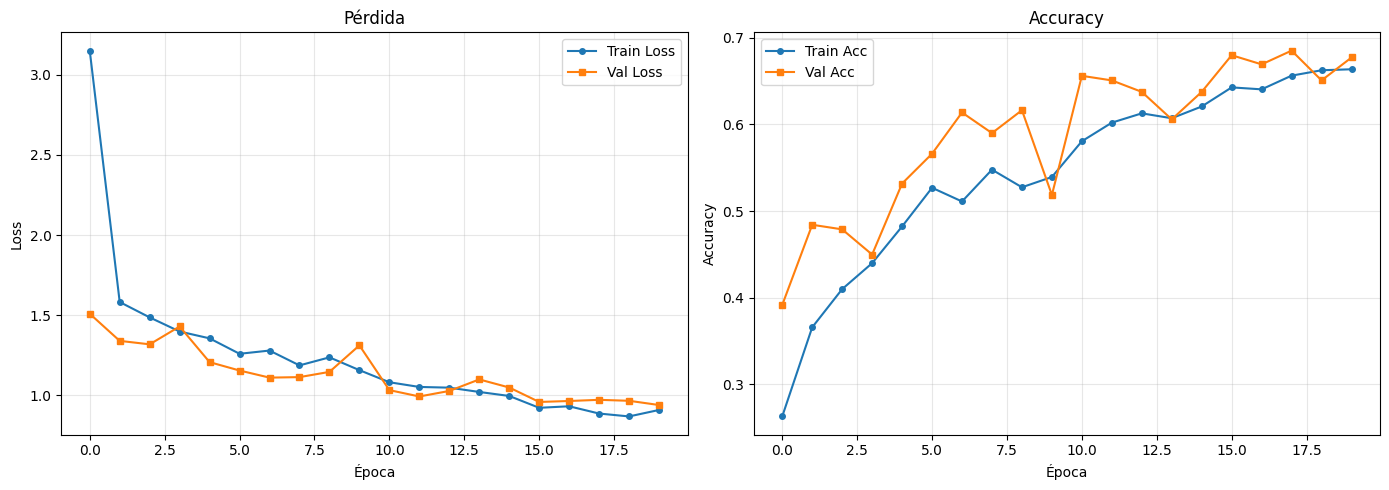

In [21]:
# Visualización del entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], label='Train Loss', marker='o', markersize=4)
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', markersize=4)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title('Pérdida')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Train Acc', marker='o', markersize=4)
axes[1].plot(history['val_acc'], label='Val Acc', marker='s', markersize=4)
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 18) Evaluación del Baseline

Evaluamos con matriz de confusión y métricas por clase.

In [22]:
# Cargar mejor modelo y obtener predicciones
model_baseline.load_state_dict(torch.load('baseline_best.pth'))
model_baseline.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_baseline(inputs)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

val_preds = np.array(all_preds)
val_labels = np.array(all_labels)
val_probs = np.array(all_probs)

val_accuracy = accuracy_score(val_labels, val_preds)
print(f"Accuracy en validación: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

Accuracy en validación: 0.6852 (68.52%)


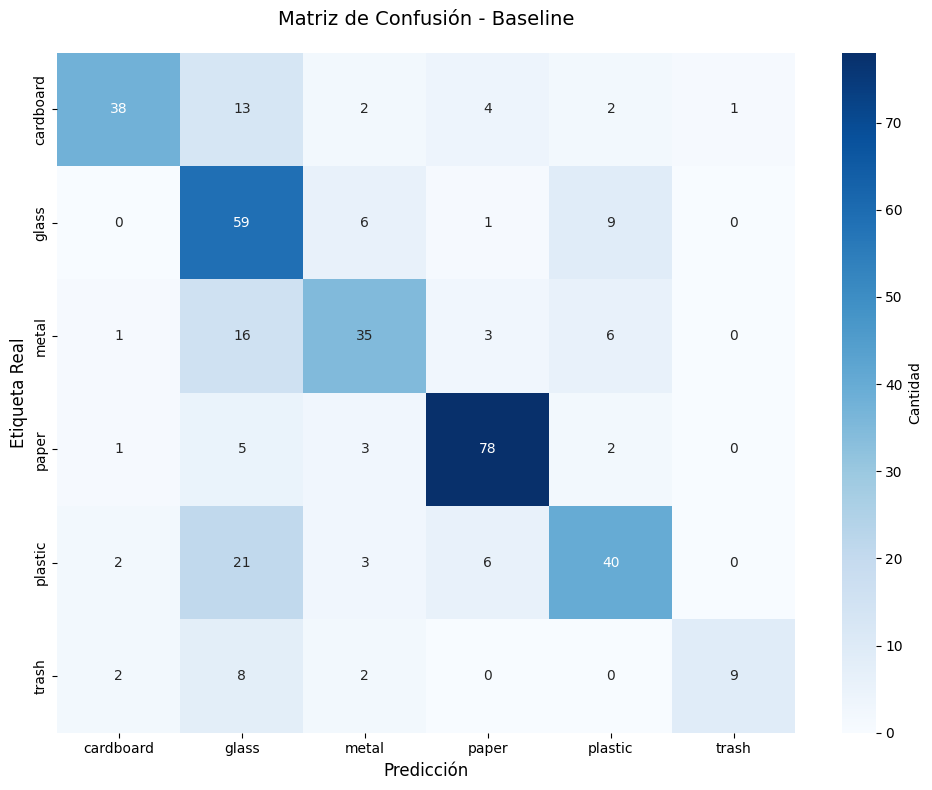


Confusiones principales (>10%):
  cardboard → glass: 13 (21.7%)
  glass → plastic: 9 (12.0%)
  metal → glass: 16 (26.2%)
  plastic → glass: 21 (29.2%)
  trash → glass: 8 (38.1%)


In [23]:
# Matriz de confusión
cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(categories), 
            yticklabels=sorted(categories),
            cbar_kws={'label': 'Cantidad'})
plt.title('Matriz de Confusión - Baseline', fontsize=14, pad=20)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.tight_layout()
plt.show()

print("\nConfusiones principales (>10%):")
for i, true_class in enumerate(sorted(categories)):
    for j, pred_class in enumerate(sorted(categories)):
        if i != j and cm[i, j] > 0:
            conf_rate = cm[i, j] / cm[i].sum() * 100
            if conf_rate > 10:
                print(f"  {true_class} → {pred_class}: {cm[i, j]} ({conf_rate:.1f}%)")

In [24]:
# Reporte de clasificación
print("Reporte de Clasificación:")
print("="*70)
report = classification_report(val_labels, val_preds, 
                               target_names=sorted(categories), digits=4)
print(report)

precision, recall, f1, support = precision_recall_fscore_support(
    val_labels, val_preds, labels=range(len(categories))
)

metrics_df = pd.DataFrame({
    'Clase': sorted(categories),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nMétricas por clase (ordenadas por F1-Score):")
print(metrics_df.sort_values('F1-Score', ascending=False).to_string(index=False))

Reporte de Clasificación:
              precision    recall  f1-score   support

   cardboard     0.8636    0.6333    0.7308        60
       glass     0.4836    0.7867    0.5990        75
       metal     0.6863    0.5738    0.6250        61
       paper     0.8478    0.8764    0.8619        89
     plastic     0.6780    0.5556    0.6107        72
       trash     0.9000    0.4286    0.5806        21

    accuracy                         0.6852       378
   macro avg     0.7432    0.6424    0.6680       378
weighted avg     0.7225    0.6852    0.6872       378


Métricas por clase (ordenadas por F1-Score):
    Clase  Precision   Recall  F1-Score  Support
    paper   0.847826 0.876404  0.861878       89
cardboard   0.863636 0.633333  0.730769       60
    metal   0.686275 0.573770  0.625000       61
  plastic   0.677966 0.555556  0.610687       72
    glass   0.483607 0.786667  0.598985       75
    trash   0.900000 0.428571  0.580645       21


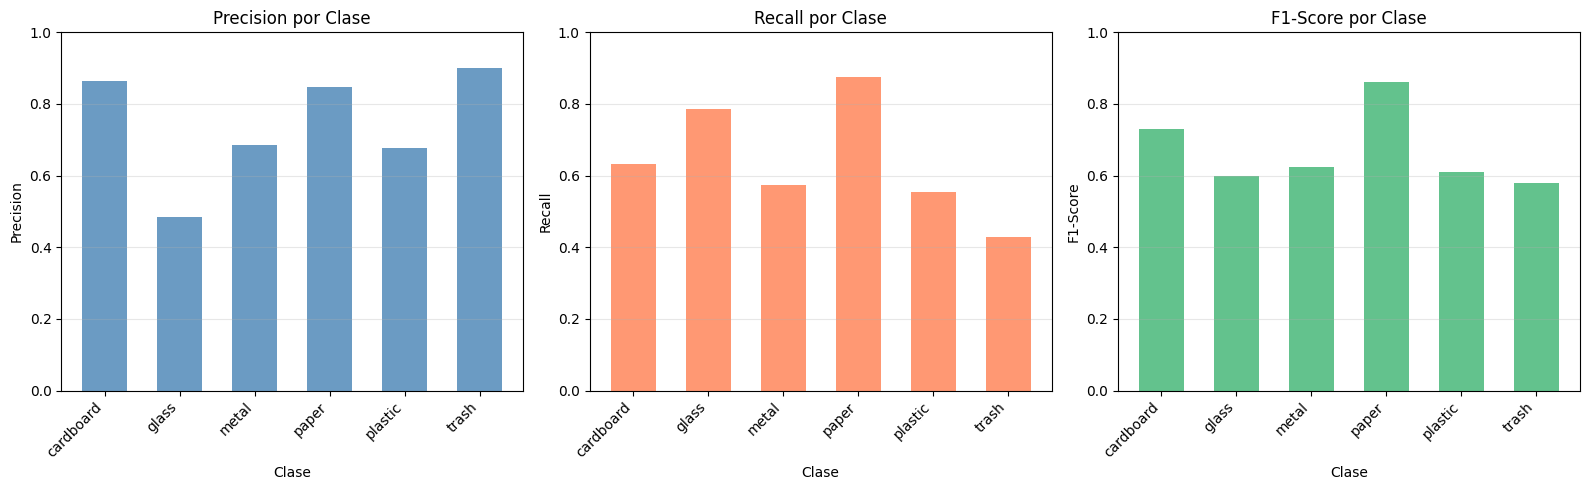

In [25]:
# Visualización de métricas por clase
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
x = np.arange(len(categories))
width = 0.6

axes[0].bar(x, precision, width, color='steelblue', alpha=0.8)
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision por Clase')
axes[0].set_xticks(x)
axes[0].set_xticklabels(sorted(categories), rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.0])

axes[1].bar(x, recall, width, color='coral', alpha=0.8)
axes[1].set_xlabel('Clase')
axes[1].set_ylabel('Recall')
axes[1].set_title('Recall por Clase')
axes[1].set_xticks(x)
axes[1].set_xticklabels(sorted(categories), rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1.0])

axes[2].bar(x, f1, width, color='mediumseagreen', alpha=0.8)
axes[2].set_xlabel('Clase')
axes[2].set_ylabel('F1-Score')
axes[2].set_title('F1-Score por Clase')
axes[2].set_xticks(x)
axes[2].set_xticklabels(sorted(categories), rotation=45, ha='right')
axes[2].grid(axis='y', alpha=0.3)
axes[2].set_ylim([0, 1.0])

plt.tight_layout()
plt.show()

## 19) Conclusiones Parciales del Baseline

A partir del EDA y baseline, extraemos conclusiones preliminares:

### 19.1) Hallazgos del EDA

**Características del Dataset:**
- **Tamaño**: 2,527 imágenes distribuidas en 6 clases
- **Desbalance**: "trash" (137 imgs) vs "paper" (594 imgs)
- **Dimensiones**: 512×512 píxeles estandarizadas
- **Calidad**: Variable en iluminación, fondo y perspectiva

**Problemas Identificados:**
1. **Similitud inter-clase**: Paper/cardboard y plastic/glass difíciles de distinguir
2. **Duplicados**: Detectados mediante hash perceptual
3. **Variabilidad intra-clase**: Alta en forma, color y textura
4. **Clase "trash"**: Heterogénea y solapa con otras clases

**Características Estadísticas:**
- Brillo promedio (gray_mean): ~165
- Contraste (gray_std): ~46
- Densidad de bordes: ~0.10 (constante)
- Color dominante: Varía por clase

### 19.2) Resultados del Baseline

**Arquitectura:**
- CNN de 4 bloques (32→64→128→256 filtros)
- Batch Normalization en cada bloque
- 3 capas FC (256×14×14 → 512 → 128 → 6)
- Dropout (0.5, 0.3) para regularización
- ~26M parámetros

**Configuración:**
- Sin data augmentation
- Adam (lr=0.001)
- CrossEntropyLoss
- Batch size: 32, 20 épocas

**Desempeño:**
- Convergencia en primeras épocas
- Brecha train/val sugiere overfitting
- Clases con mejor desempeño: metal, glass (distintivas)
- Peor desempeño: trash (heterogénea, pocos ejemplos)